# Sentiment Analysis: Large Movie Review Dataset

Hi again! You will be expected to finish this on your own, but you can use the available channels on Discord to ask questions and help others. Please read the entire notebook before starting, this will give you a better idea of what you need to accomplish.

This project is related to NLP. As you may already know, the most important and hardest part of an NLP project is pre-processing, which is why we are going to focus on that.

Regarding the data, we are not going to have a __csv file__, that would be too easy :) instead we are going to download the data from [AI Stanford Dataset](https://ai.stanford.edu/~amaas/data/sentiment/). When you download them you will notice that their format is text files, so you will have to work a little there to be able to use and process them. This is a dataset for __binary sentiment classification__.

Basically a basic sentiment analysis problem, as in this case, consists of a classification problem, where the possible output labels are: `positive` and `negative`. Which indicates, if the review of a movie speaks positively or negatively. In our case it is a binary problem, but one could have many more "feelings" tagged and thus allow a more granular analysis.

### These are the objectives of the project:

* Read data that is not in a traditional format.
* Put together a set of preprocessing functions that we can use later on any NLP or related problems.
* Vectorize the data in order to apply a machine learning model to it: using BoW or TF-IDF.
* BoW and TF-IDF are classic ways to vectorize text, but currently we have some more complex ways with better performance, for this we are going to train our own word embedding and use it as a vectorization source for our data.
* Train a sentiment analysis model that allows us to detect positive and negative opinions in movie reviews.

In [1]:
#your first time run this 
#!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz

In [2]:
import os
import numpy as np
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from gensim.models import Word2Vec
import gensim.downloader as api
import nltk
from nltk.tokenize.toktok import ToktokTokenizer

import text_normalizer
import evaluation

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /home/app/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


---
## 1. Get the data

#### Download the data and process it in order to obtain:

* `X_train:` list with reviews for training.
* `y_train:` list with labels for training.
* `X_test:` list with reviews for testing.
* `y_test:` list with labels for testing.

`Notes:` Use the target column as `positive`, that way the positive value will be indicated with a value of `1` and negative with a value of `0`. In this case, a split train/test is not necessary because the original data is already separated.

In [3]:
def walkdir(folder):
    """
    Walk through all the files in a directory and its subfolders.

    Parameters
    ----------
    folder : str
        Path to the folder you want to walk.

    Returns
    -------
        For each file found, yields a tuple having the path to the file
        and the file name.
    """
    for dirpath, _, files in os.walk(folder):
        for filename in files:
            yield (dirpath, filename)


def create_dataset(folder):
    '''
    Walk through the folder and append the content in different lists to create the dataset.
    
    Parameters
    ----------
    folder : str
        Path to the folder you want to walk.

    Returns
    -------
        X_train : list
        y_train : list
        X_test : list
        y_test : list
    '''
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    for dirpath, filename in tqdm(walkdir(folder)):
        path_txt = os.path.join(dirpath, filename)
        label=os.path.basename(dirpath)
        train_or_test=os.path.basename(os.path.dirname(dirpath))
        if train_or_test=='train' and label != 'unsup':
            with open (path_txt,'r',encoding = 'utf-8') as f:
                content=f.read()
                f.seek(0)
            X_train.append(content)
            y_train.append(label)
        elif train_or_test=='test':
            with open (path_txt,'r',encoding = 'utf-8') as f:
                content=f.read()
                f.seek(0)
            X_test.append(content)
            y_test.append(label)

    y_train = [0 if word == 'neg' else 1 for word in y_train]
    y_test =  [0 if word == 'neg' else 1 for word in y_test]
    
    return X_train, y_train ,X_test, y_test


In [4]:
folder='../src/movie_reviews_dataset'
X_train, y_train ,X_test, y_test = create_dataset(folder)

0it [00:00, ?it/s]

### *Don't change anything in this block, just make it run correctly*

We are going to check that you have done it right and for that we are going to see if the dimensions match.

In [5]:
def check_data(X_train, y_train, X_test, y_test):
    if len(X_train) == len(y_train) == len(X_test) == len(y_test) == 25000:
        print('Reading Data Success!')
    else:
        raise ValueError('Dimensions do not match!')

check_data(X_train, y_train, X_test, y_test)

Reading Data Success!


---
## 2. Normalize the data

#### Create the following functions but not here in the notebook, do it in the python script called `text_normalizer.py` and import them into the notebook (this way you can build your own NLP preprocessing library). In fact, the structure of the functions is already written, you must complete them with the code that you consider necessary.

#### Respect names and minimal interfaces:

* `remove_html_tags(text):` to remove all HTML tags that may be present in text.
* `remove_accented_chars(text):` to remove accented characters from text
* `expand_contractions(text):` to expand contractions of the type, "don't" to "do not". The contractions are already defined in the "contractions.py" file.
* `lemmatize_text(text):` to lemmatize text.
* `stem_text(text):` to apply stemming (NLTK's PorterStemmer) on text.
* `remove_special_chars(text):` to remove special characters from text.
* `remove_special_chars(text, remove_digits=True):` to remove numbers, note that it is the same function to remove special characters with the addition of an argument that enables or disables the removal of numbers.
* `remove_stopwords(text, stopwords=stop_words):` to remove stopwords from text.
* `remove_extra_new_lines(text):` to remove extra newlines from text.
* `remove_extra_whitespace(text):` to remove extra whitespaces from text.

If you want to add more features that would be great, for example you could start by removing emojis, using different stemming algorithms, etc. The more functions you have the better, remember that the texts are very varied and the preprocessing depends a lot on the source of our data.

To apply each of the functions you created and pre-process the dataset, you must use the `normalize_corpus` function of the `text_normalizer.py` script. In this method each of the functions you wrote is called, in fact you must enable or disable what you consider necessary (`at this point we leave it to your free choice, for example: you can lemmatize or apply stemming or directly not apply any of the two and so on with the rest, but that is your choice`), this function simply groups the previous ones for a more simplified use.

### *Don't change anything in this block, just make it run correctly*

We are going to check that the pre-processing does what we need it to do, for this we are going to test the functions with predefined inputs and we are going to see if the outputs match what we are looking for.

Note that the functions are not defined in the notebook itself, but rather that they are in a python file and you must import them in order to use them. Same thing with names, you're going to have to name your functions the way they were named.

In [6]:
nltk.download('punkt')
# Inputs
doc_html = """
<br /><br />But with plague out there and the news being kept a secret,
the New Orleans PD starts a dragnet of the city's underworld.
"""
doc_accented = "Héllo, thís is an accented sénténce."
doc_contractions = "I can't, because it doesn't work."
doc_lemma = "The striped bats are hanging on their feet for best"
doc_stem = """
Where did he learn to dance like that?
His eyes were dancing with humor.
She shook her head and danced away.
"""
doc_specials = "hello? there A-Z-R_T(,**), world, welcome to python. this **should? the next line#followed- by@ an#other %million^ %%like $this."
doc_digits = "abc123def456ghi789zero0 hello my friend number 10"
doc_stop = "He is a very good person"
doc_new_lines = """we
use
a
lot
of
lines"""
doc_spaces = "Hello           my      dear          friend"

# Outputs
good_html = """
But with plague out there and the news being kept a secret,
the New Orleans PD starts a dragnet of the city's underworld.
"""
good_accented = "Hello, this is an accented sentence."
good_contractions = "I cannot, because it does not work."
good_lemma = "the stripe bat be hang on their foot for good"
good_stem = "where did he learn to danc like that ? hi eye were danc with humor. she shook her head and danc away ."
good_specials = "hello there AZRT world welcome to python this should the next linefollowed by another million like this"
good_digits = "abcdefghizero hello my friend number "
good_stop = "good person"
good_new_lines = "we use a lot of lines"
good_spaces = "Hello my dear friend"
stop_words = nltk.corpus.stopwords.words('english')

def check_normalization():
    if good_html == text_normalizer.remove_html_tags(doc_html):
        print('[1/10] Remove HTML Success!')
    else:
        raise ValueError('[1/10] Remove HTML Fail!')
        
    if good_accented == text_normalizer.remove_accented_chars(doc_accented):
        print('[2/10] Remove Accented Success!')
    else:
        raise ValueError('[2/10] Remove Accented Fail!')
        
    if good_contractions == text_normalizer.expand_contractions(doc_contractions):
        print('[3/10] Expand Contractions Success!')
    else:
        raise ValueError('[3/10] Expand Contractions Fail!')
        
    if good_lemma == text_normalizer.lemmatize_text(doc_lemma):
        print('[4/10] Lemmatization Success!')
    else:
        raise ValueError('[4/10] Lemmatization Fail!')
        
    #print(text_normalizer.stem_text(doc_stem))
    if good_stem == text_normalizer.stem_text(doc_stem):
        print('[5/10] Stemming Success!')
    else:
        raise ValueError('[5/10] Stemming Fail!')
        
    if good_specials == text_normalizer.remove_special_chars(doc_specials):
        print('[6/10] Remove Specials Success!')
    else:
        raise ValueError('[6/8] Remove Specials Fail!')
        
    if good_digits == text_normalizer.remove_special_chars(doc_digits, remove_digits=True):
        print('[7/10] Remove Digits Success!')
    else:
        raise ValueError('[7/10] Remove Digits Fail!')
        
    if good_stop == text_normalizer.remove_stopwords(doc_stop, stopwords=stop_words):
        print('[8/10] Remove Stopwords Success!')
    else:
        raise ValueError('[8/10] Remove Stopwords Fail!')
    
    if good_new_lines == text_normalizer.remove_extra_new_lines(doc_new_lines):
        print('[9/10] Remove New Lines Success!')
    else:
        raise ValueError('[9/10] Remove New Lines Fail!')
        
    if good_spaces == text_normalizer.remove_extra_whitespace(doc_spaces):
        print('[10/10] Remove Extra Whitespaces Success!')
    else:
        raise ValueError('[10/10] Remove Extra Whitespaces Fail!')

check_normalization()


[1/10] Remove HTML Success!
[2/10] Remove Accented Success!
[3/10] Expand Contractions Success!
[4/10] Lemmatization Success!
[5/10] Stemming Success!
[6/10] Remove Specials Success!
[7/10] Remove Digits Success!
[8/10] Remove Stopwords Success!
[9/10] Remove New Lines Success!
[10/10] Remove Extra Whitespaces Success!


[nltk_data] Downloading package punkt to /home/app/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
#I use stemming because has the best performance in my experiments.
X_train_normalized_stemm=text_normalizer.normalize_corpus(X_train,text_stemming=True)
X_test_normalized_stemm=text_normalizer.normalize_corpus(X_test,text_stemming=True)


  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

---
## 3. Feature Engineering

You already have the pr-eprocessed data, now you must vectorize them, because remember that the models only understand numbers. At this stage choose whether you want to vectorize with BoW or with TF-IDF. Later we will train our own embedding but for now we go with a more "classic" vectorization.

In [8]:
#Tf-IDF with stemming

max_features=1000
tfidf_vectorizer = TfidfVectorizer(max_features=max_features)
values_train = tfidf_vectorizer.fit_transform(X_train_normalized_stemm)
values_test = tfidf_vectorizer.transform(X_test_normalized_stemm)

feature_names = tfidf_vectorizer.get_feature_names_out()
stemm_df_train=pd.DataFrame(values_train.toarray(), columns = feature_names)
stemm_df_test=pd.DataFrame(values_test.toarray(), columns = feature_names)
stemm_df_train

,abil,abl,abov,absolut,accent,accept,achiev,across,act,action,...,written,wrong,wrote,ye,year,yet,york,young,younger,zombi
0,0.000000,0.0000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.000000,0.0000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.017936,0.025327,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.000000,0.0000,0.000000,0.0,0.0,0.0,0.0,0.169596,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
3,0.000000,0.0000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
4,0.104565,0.0000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0.000000,0.0000,0.182806,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
24996,0.000000,0.0000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
24997,0.000000,0.0000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.055197,0.000000,0.0,0.0,0.0,0.0
24998,0.000000,0.1213,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.099403,...,0.0,0.0,0.0,0.0,0.240565,0.000000,0.0,0.0,0.0,0.0


## 4. Modeling and Performance Evaluation

As we said at the beginning, what interests us most in this part is pre-processing. However, we must train a model, so choose a model of your choice (obviously a classification model, given the problem we are facing) and apply everything we learned. Also if you want you can try several models, the more models you use and know better!

In addition to training the model we ask you to show:

* `Precision`
* `Recall`
* `F1-Score`
* `Classification Report`
* `Confusion Matrix`

To do this you must complete the `get_performance` function of the `evaluation.py` script.

Also, you must complete the `plot_roc` function so that it can show:

* `ROC Curve`
* `Obtain the ROC-AUC value (later we will do a small minimum performance check with this value)`

Model Performance metrics:
------------------------------
Accuracy: 0.85864
Precision: 0.8506178632879712
Recall: 0.87008
F1 Score: 0.8602388673574308

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.85      0.87      0.86     12500
           0       0.87      0.85      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000


Prediction Confusion Matrix:
------------------------------
       0      1
0  10876   1624
1   1910  10590


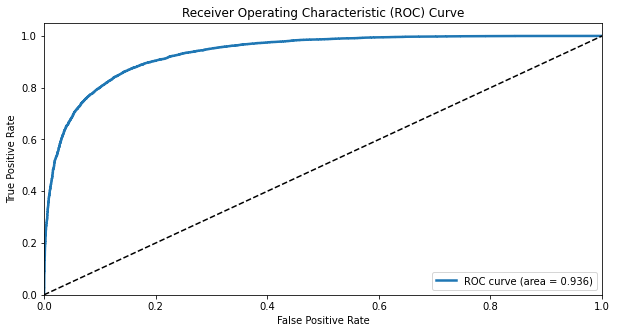

roc auc score: 0.936


In [9]:
lr_model = LogisticRegression(random_state=42)
lr_model.fit(stemm_df_train,y_train)
y_pred=lr_model.predict(stemm_df_test)
accuracy, precision, recall, f1_score=evaluation.get_performance(y_pred,y_test)
roc_auc=evaluation.plot_roc(lr_model,y_test,stemm_df_test)
print(f'roc auc score: {round(roc_auc,4)}')

### *Don't change anything in this block, just make it run correctly*

Let's check that the `get_performance` function returns the metrics correctly. For that we are going to simulate input/output data of a model.

In [10]:
def check_basic_metrics():
    accuracy, precision, recall, f1_score = evaluation.get_performance(
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0], 
        [1, 1, 1, 0, 0, 1, 1, 0, 0, 0]
    )
    
    if (accuracy, precision, recall, f1_score) == (0.6, 0.6, 0.6, 0.6):
        print('Success!')
    else:
        raise ValueError('You must check your get_performance function!')
        
check_basic_metrics()

Model Performance metrics:
------------------------------
Accuracy: 0.6
Precision: 0.6
Recall: 0.6
F1 Score: 0.6

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.60      0.60      0.60         5
           0       0.60      0.60      0.60         5

    accuracy                           0.60        10
   macro avg       0.60      0.60      0.60        10
weighted avg       0.60      0.60      0.60        10


Prediction Confusion Matrix:
------------------------------
   0  1
0  3  2
1  2  3
Success!


Let's see if your model at least exceeds an ROC-AUC of 0.9

In [11]:
def check_roc(roc_auc):
    if roc_auc > 0.9:
        print('Success!')
    else:
        raise ValueError('Your model is not good enough!')
        
check_roc(roc_auc)

Success!


---
## 5. Feature Engineering with Custom Word Embedding

### Tokenize reviews and train your own Word Embedding

You are going to have to train your own word embedding, for this we are going to use the __gensim__ library. The only requirement we ask of you is that the $vector\_size=100$.

[Here](https://radimrehurek.com/gensim/models/word2vec.html) you can read Gensim's Word2Vec documentation so you can train your own embedding, using the review data as a corpus.

As a previous step to training your word embedding you must tokenize the corpus, this may take a bit depending on the size of the dataset and the tokenizer we use, if you want you can try the NLTK tokenizer called `ToktokTokenizer`, which turns out to be a little faster (we hope that this recommendation does not bias your work, try and use the ones you want)

In [12]:
tokenizer = ToktokTokenizer()

In [13]:
tokens_train=[]
for token in tqdm(X_train_normalized_stemm):
    tokens_train.append(tokenizer.tokenize(token))

tokens_test=[]
for token in tqdm(X_test_normalized_stemm):
    tokens_test.append(tokenizer.tokenize(token))

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

In [14]:
%%time
model_w2v =  Word2Vec(sentences=tokens_train, vector_size=100, window=5, workers=8,sg = 1,epochs=50) 

CPU times: user 20min 22s, sys: 6.51 s, total: 20min 29s
Wall time: 3min 33s


### Generate averaged word vector features

Once the embedding has been trained, we must use it. Remember that embedding will convert each word you pass to it into a vector of a given dimension (in our case $vector\_size=100$). So in order to obtain a vector for each review, you must average the vectors of all the words that are part of the same review.

The function must have the following form:
* `vectorizer(corpus, model, num_features=100)`


Where:
* `corpus:` corresponds to the entire dataset, in this way we obtain an average vector for each review, with a single call to the function.
* `model:` is your trained model.
* `num_features:` the dimension of the output vector of your embedding (remember that in our case we set this value to 100).

In [15]:
def vectorizer(corpus, model, num_features=100):
    # Put your code
    corpus_vectors=[]
    for review in tqdm(corpus):
        words= [model[word] for word in review if word in model.key_to_index]
        corpus_vectors.append(sum(words)/len(words))
    return corpus_vectors

In [16]:
vector_train=vectorizer(tokens_train,model_w2v.wv)
vector_test=vectorizer(tokens_test,model_w2v.wv)


  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

### *Don't change anything in this block, just make it run correctly*

Let's do a simple check of the embedding that you just trained.

In [17]:
def check_embedding(model):
    vector = model.wv['computer']
    if len(vector) == 100:
        print(
            'Success! Your embedding tells me that "women" and "man" '
            f'are similar with a score of {model.wv.similarity("woman", "man")}'
        )
    else:
        raise ValueError('You should check your embedding vector size!')
        
check_embedding(model_w2v)

Success! Your embedding tells me that "women" and "man" are similar with a score of 0.6703975200653076


Now, we are going to check the vectorizer, remember that the vectorizer must generate an average vector of all the words present in the same review. So we're going to get two vectors of two words and manually average them, then using those two words we'll simulate a tokenized sentence and see that it matches the manual way.

In [18]:
def check_vectorizer(model):
    vector1 = model.wv['personal']
    vector2 = model.wv['computer']
    avg = vectorizer([['personal', 'computer']], model.wv)[0]

    if np.allclose((vector1 + vector2) / 2, avg):
        print('Success!')
    else:
        raise ValueError('You should check your vectorizer!')
        
check_vectorizer(model_w2v)

  0%|          | 0/1 [00:00<?, ?it/s]

Success!


### Modeling

Finally train a new model, it can be the same one you used before and compare the results you got using BoW/TF-IDF and Word2Vec.

In addition to training the model we ask you to show:

* `Accuracy`
* `Recall`
* `F1-Score`
* `Classification Report`
* `Confusion Matrix`
* `ROC Curve`
* `Obtain the ROC-AUC value (later we will do a small minimum performance check with this value)`

Model Performance metrics:
------------------------------
Accuracy: 0.84772
Precision: 0.8534601935431406
Recall: 0.8396
F1 Score: 0.8464733637133524

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.85      0.84      0.85     12500
           0       0.84      0.86      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000


Prediction Confusion Matrix:
------------------------------
       0      1
0  10495   2005
1   1802  10698


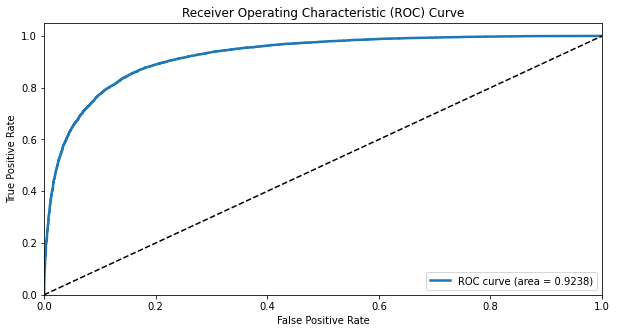

roc auc score: 0.9238


In [19]:
lr_model_stemm = LogisticRegression(random_state=42,max_iter=1000)
lr_model_stemm.fit(vector_train,y_train)
y_pred=lr_model_stemm.predict(vector_test)
accuracy, precision, recall, f1_score=evaluation.get_performance(y_pred,y_test)
roc_auc=evaluation.plot_roc(lr_model_stemm,y_test,vector_test)
print(f'roc auc score: {round(roc_auc,4)}')

Fitting 4 folds for each of 50 candidates, totalling 200 fits
Model Performance metrics:
------------------------------
Accuracy: 0.84884
Precision: 0.8566871165644172
Recall: 0.83784
F1 Score: 0.8471587462082913

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.86      0.84      0.85     12500
           0       0.84      0.86      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000


Prediction Confusion Matrix:
------------------------------
       0      1
0  10473   2027
1   1752  10748


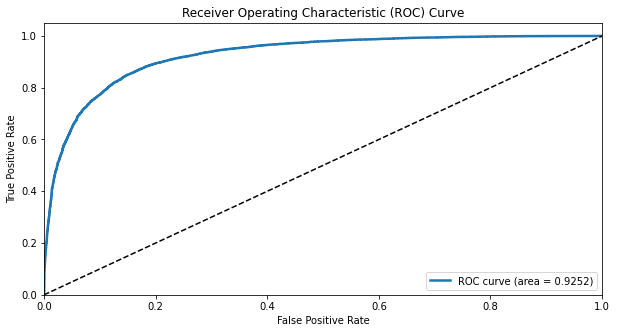

roc auc score: 0.9252
CPU times: user 2min 10s, sys: 1.63 s, total: 2min 11s
Wall time: 2min 20s


In [20]:
%%time

#using random search cv to find the best hyperparameters
param_grid = {
 'tol':[0.0001,0.001,0.00001,0.01,0.1,0.5],
 'C':[1.0,0.1,0.01,10.0,100.0],
 'max_iter':[1000,10000,5000],
}
lr_model=LogisticRegression(n_jobs=-1, random_state=42)
random_search_lr=RandomizedSearchCV(lr_model, param_grid, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=4,
                                 random_state=42,verbose=1)

random_search_lr.fit(vector_train,y_train)
y_pred=random_search_lr.predict(vector_test)
accuracy, precision, recall, f1_score=evaluation.get_performance(y_pred,y_test)
roc_auc=evaluation.plot_roc(random_search_lr,y_test,vector_test)
print(f'roc auc score: {round(roc_auc,4)}')

### *Don't change anything in this block, just make it run correctly*

In [21]:
check_roc(roc_auc)

Success!


---
### OPTIONAL:

In our case, we train a word embedding from scratch, which is very good at an educational level, but when applying it to a real problem, we need a lot of data (which is not the case with our problem). Therefore, we invite you to investigate and use one of the `pre-trained Word2Vec models`.

If you look for the `Pretrained models` section in this [link](https://radimrehurek.com/gensim/models/word2vec.html), you will find information about the models that Gensim owns.

In [22]:
info=api.info()['models']
for key in info.keys():
    if key != '__testing_word2vec-matrix-synopsis':
        print('Name: ',key)
        print('Size Mb: ',info[key]['file_size']/1000000)
        print('Description: ',info[key]['description'])

Name:  fasttext-wiki-news-subwords-300
Size Mb:  1005.007116
Description:  1 million word vectors trained on Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens).
Name:  conceptnet-numberbatch-17-06-300
Size Mb:  1225.497562
Description:  ConceptNet Numberbatch consists of state-of-the-art semantic vectors (also known as word embeddings) that can be used directly as a representation of word meanings or as a starting point for further machine learning. ConceptNet Numberbatch is part of the ConceptNet open data project. ConceptNet provides lots of ways to compute with word meanings, one of which is word embeddings. ConceptNet Numberbatch is a snapshot of just the word embeddings. It is built using an ensemble that combines data from ConceptNet, word2vec, GloVe, and OpenSubtitles 2016, using a variation on retrofitting.
Name:  word2vec-ruscorpora-300
Size Mb:  208.427381
Description:  Word2vec Continuous Skipgram vectors trained on full Russian National Corpus (abo

In [23]:
glove_vectors = api.load('glove-wiki-gigaword-300')

In [24]:
#use only basic cleaning for this experiment because have the best result.
X_train_normalized=text_normalizer.normalize_corpus(X_train)
X_test_normalized=text_normalizer.normalize_corpus(X_test)

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

In [25]:
tokens_train=[]
for token in tqdm(X_train_normalized):
    tokens_train.append(tokenizer.tokenize(token))

tokens_test=[]
for token in tqdm(X_test_normalized):
    tokens_test.append(tokenizer.tokenize(token))

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

In [26]:
vector_train=vectorizer(tokens_train,glove_vectors)
vector_test=vectorizer(tokens_test,glove_vectors)

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

Model Performance metrics:
------------------------------
Accuracy: 0.832
Precision: 0.8314167065963903
Recall: 0.83288
F1 Score: 0.8321477100151866

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.83      0.83      0.83     12500
           0       0.83      0.83      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000


Prediction Confusion Matrix:
------------------------------
       0      1
0  10411   2089
1   2111  10389


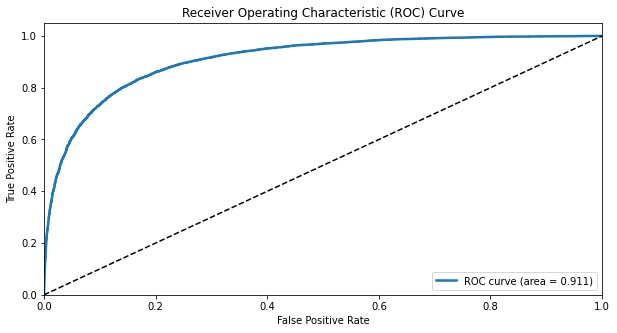

roc auc score: 0.911


In [27]:
lr_model = LogisticRegression(random_state=42,max_iter=1000)
lr_model.fit(vector_train,y_train)
y_pred=lr_model.predict(vector_test)
accuracy, precision, recall, f1_score=evaluation.get_performance(y_pred,y_test)
roc_auc=evaluation.plot_roc(lr_model,y_test,vector_test)
print(f'roc auc score: {round(roc_auc,4)}')